# Probabilistic Programming - 2

## Monte Carlo sampling

In this notebook, we are exploring a more complex problem set using Monte Carlo sampling, namely mixture modeling. It will show you how to extend the sampling procedure to the multivariate case.

### Preliminaries

- Goal 
  - Write a Monte Carlo sampling procedure for a 2-dimensional mixture model.
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - Cheatsheets: [how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).
    - Tutorials using [Turing.jl](https://turing.ml/dev/tutorials/0-introduction/)

## Mixture modeling

We will first generate a synthetic data set to play around. This will let us focus on the data-generating process and on the point that a good model should follow the data-generating process.

In [11]:
using Pkg;Pkg.activate("workspace");Pkg.instantiate()

Activating environment at `~/Documents/biaslab/repos/BMLIP/lessons/notebooks/probprog/workspace/Project.toml`


In [2]:
using Revise
using Random
using Distributions
using StatsPlots
using LaTeXStrings

# Set a random seed.
Random.seed!(3);

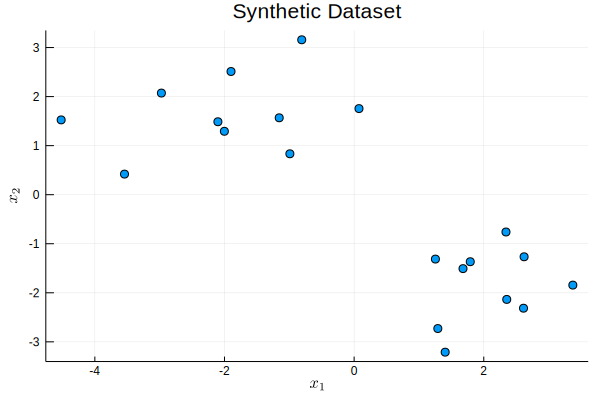

In [3]:
# Construct 10 data points for each cluster.
N = 10

# Means for each cluster, assuming each cluster is Gaussian distributed
μs = [[-2 +2]; 
      [+2 -2]]

# Cluster 1
X1 = randn(N,2)
for i = 1:N
    X1[i,:] += μs[1,:]
end 
    
# Cluster 2
X2 = randn(N,2)
for i = 1:N
    X2[i,:] += μs[2,:]
end 
    
# Concatenate clusters
X = [X1; X2]

# ForneyLab needs every vector to be a row
X_ = [X[i,:] for i = 1:N*2]

# Visualization.
scatter(X[:,1], X[:,2], legend = false, title = "Synthetic Dataset")
xlabel!(L"$x_1$")
ylabel!(L"$x_2$")

### Monte Carlo Sampling via Turing.jl

With MC sampling, we can obtain samples from the posterior distribution. These are used to approximate the expected value, variance, etc. Below, we will draw samples from the posterior distribution of cluster assignment. Those samples are averaged to approximate the _expected_ cluster assignment of each data point.

First, we will import Turing.jl and the package containing the sampler. The script being included contains utility functions, important for plotting and diagnosing.

In [4]:
using Turing
using MCMCChains
Turing.setadbackend(:forward_diff)
include("../scripts/pp-2.jl");


┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1273


ArgumentError: ArgumentError: Package MCMCChains not found in current path:
- Run `import Pkg; Pkg.add("MCMCChains")` to install the MCMCChains package.


We will now define the Gaussian Mixture model.

In [5]:
@model GaussianMixtureModel(x, m1, m2) = begin
    
    D, N = size(x)

    # Draw the mean for cluster 1 [2x1 vector]
    μ1 ~ MvNormal(m1, 1.)
    
    # Draw the mean for cluster 2 [2x1 vector]
    μ2 ~ MvNormal(m2, 1.)
    
    # Concatenate means [2x2 matrix]
    μ = [μ1 μ2]
    
    # Probability of belonging to each cluster [2x1 vector]
    w = [0.5, 0.5]
    
    # Preallocate assignment vector [Nx1 vector]
    k = Vector{Int}(undef, N)
    
    # Loop over observations
    for i in 1:N
        
        # Draw assignment for i-th sample from a Categorical distribution parameterized by w
        k[i] ~ Categorical(w)
        
        # Data point x[i] follows a normal distribution, with mean indexed by the assignment variable k[i]
        x[:,i] ~ MvNormal(μ[:, k[i]], 1.)
    end
    
    # Return the assignments
    return k
end

"Call an instance of the defined Gaussian Mixture model"

# Set priors
m1 = [-2, -2]
m2 = [0, 0]

# Create an instance of a model, using the synthetic data set X
gmm_model = GaussianMixtureModel(X, m1, m2);

We now have a data set and a model. To arrive at class assignments for each data point, we need to perform inference. As stated before, there are two main schools of thought in Bayesian inference: Monte Carlo sampling and variational approximations. Below, we will use a particular form of Monte Carlo sampling, called Gibbs sampling.

In [6]:
# Construct Gibbs sampler
gmm_sampler = Gibbs(PG(50, :k), HMC(0.05, 10, :μ1, :μ2))

# Start sampling
tchain = mapreduce(c -> sample(gmm_model, gmm_sampler, 100), chainscat, 1);

UndefVarError: UndefVarError: chainscat not defined

In [7]:
# Extract the means over the MCMC chains for the posterior means
μ1_estimated = vec(convert(Array{Float64,2}, mean(tchain[:μ1].value.data[:,:,1]; dims=1)));
μ2_estimated = vec(convert(Array{Float64,2}, mean(tchain[:μ2].value.data[:,:,1]; dims=1)));

# Report differences between estimated mean and true means
println("Difference between μ1 and μ1_estimated = "*string(abs.(μ1 - μ1_estimated)))
println("Difference between μ2 and μ2_estimated = "*string(abs.(μ2 - μ2_estimated)))

UndefVarError: UndefVarError: tchain not defined

In [8]:
# Plot data and overlay estimated posterior probabilities
plot_posteriors(X, μ1_estimated, μ2_estimated)

UndefVarError: UndefVarError: plot_posteriors not defined

Let's take a closer look at the chain. 

In [9]:
# Find the means within the chain
ids = findall(map(name -> occursin("μ", name), names(tchain)));

# Plot the course of the chains
p=plot(tchain[:, ids, :], labels = ["mu_11" "mu_12" "mu_21" "mu_22"], colordim=:parameter)

UndefVarError: UndefVarError: tchain not defined